In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf 
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam


#ignoring Warnings 
import warnings
warnings.simplefilter('ignore') 

import os,cv2,json
from PIL import Image

In [8]:
WORK_DIR='cassava-leaf-disease-classification/'
os.listdir(WORK_DIR)

['label_num_to_disease_map.json',
 'sample_submission.csv',
 'test_images',
 'test_tfrecords',
 'train.csv',
 'train_images',
 'train_tfrecords']

# First look at the data


In [4]:
print('Train images: %d' %len(os.listdir(
    os.path.join(WORK_DIR, "train_images"))))

Train images: 21397


In [5]:
with open(os.path.join(WORK_DIR,'label_num_to_disease_map.json')) as file:
    print(json.dumps(json.loads(file.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [6]:
train_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
train_labels.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [7]:
train_labels['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

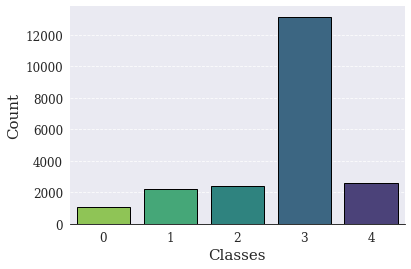

In [8]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize = (6, 4))

for i in ['top', 'right', 'left']:
    ax.spines[i].set_visible(False)
ax.spines['bottom'].set_color('black')

sns.countplot(train_labels.label, edgecolor = 'black',
              palette = reversed(sns.color_palette("viridis", 5)))
plt.xlabel('Classes', fontfamily = 'serif', size = 15)
plt.ylabel('Count', fontfamily = 'serif', size = 15)
plt.xticks(fontfamily = 'serif', size = 12)
plt.yticks(fontfamily = 'serif', size = 12)
ax.grid(axis = 'y', linestyle = '--', alpha = 0.9)
plt.show()

# Some photos of "0": "Cassava Bacterial Blight (CBB)"

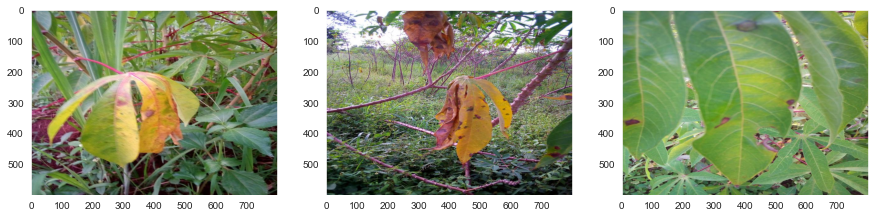

In [9]:
sample = train_labels[train_labels.label == 0].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("on")
    
plt.show()

# Some photos of "1": "Cassava Brown Streak Disease (CBSD)"

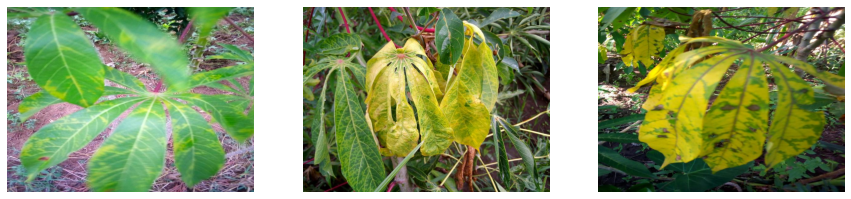

In [10]:
sample = train_labels[train_labels.label == 1].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
plt.show()

# Some photos of "2": "Cassava Green Mottle (CGM)"

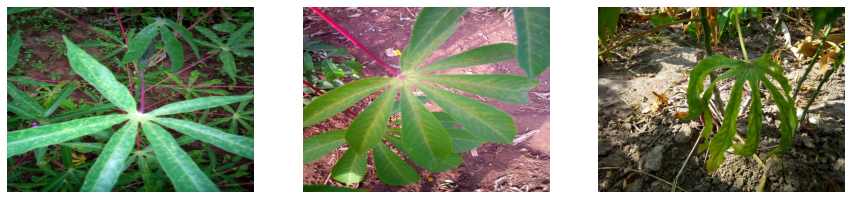

In [11]:
sample = train_labels[train_labels.label == 2].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

# Some photos of "3": "Cassava Mosaic Disease (CMD)"

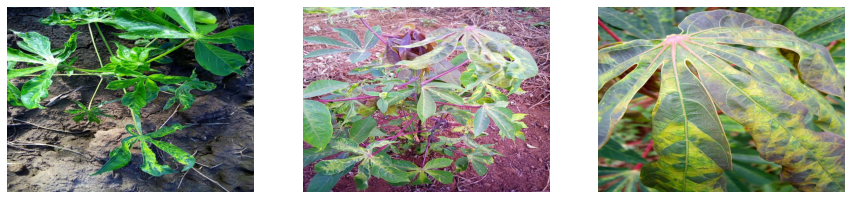

In [12]:
sample = train_labels[train_labels.label == 3].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

# Some photos of "4": "Healthy"

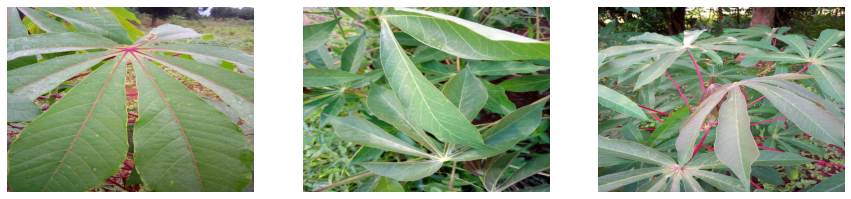

In [13]:
sample = train_labels[train_labels.label == 4].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

# Baseline label of Accuracy 

In [14]:
y_pred = [3] * len(train_labels.label)
print('The baseline accuracy: %.3f' 
      %accuracy_score(y_pred, train_labels.label))

The baseline accuracy: 0.615


In [15]:
#That means the prepared model accuracy will be better then 0.615

# Preparation for modeling

In [16]:
# Main parameters
BATCH_SIZE = 64
STEPS_PER_EPOCH = len(train_labels)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_labels)*0.2 / BATCH_SIZE
EPOCHS = 1
TARGET_SIZE = 512

# Image Data Generator 

In [17]:
train_labels.label = train_labels.label.astype('str')

train_datagen = ImageDataGenerator(validation_split = 0.2,
                                     preprocessing_function = None,
                                     rotation_range = 45,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     fill_mode = 'nearest',
                                     shear_range = 0.1,
                                     height_shift_range = 0.1,
                                     width_shift_range = 0.1)

train_generator = train_datagen.flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")


validation_datagen = ImageDataGenerator(validation_split = 0.2)

validation_generator = validation_datagen.flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


# Random photo before augmentation

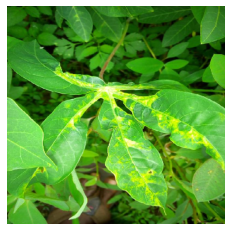

In [18]:
img_path = os.path.join(WORK_DIR, "train_images", train_labels.image_id[20])
img = image.load_img(img_path, target_size = (TARGET_SIZE, TARGET_SIZE))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255

plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

# This photo after augmentation

Found 1 validated image filenames belonging to 1 classes.


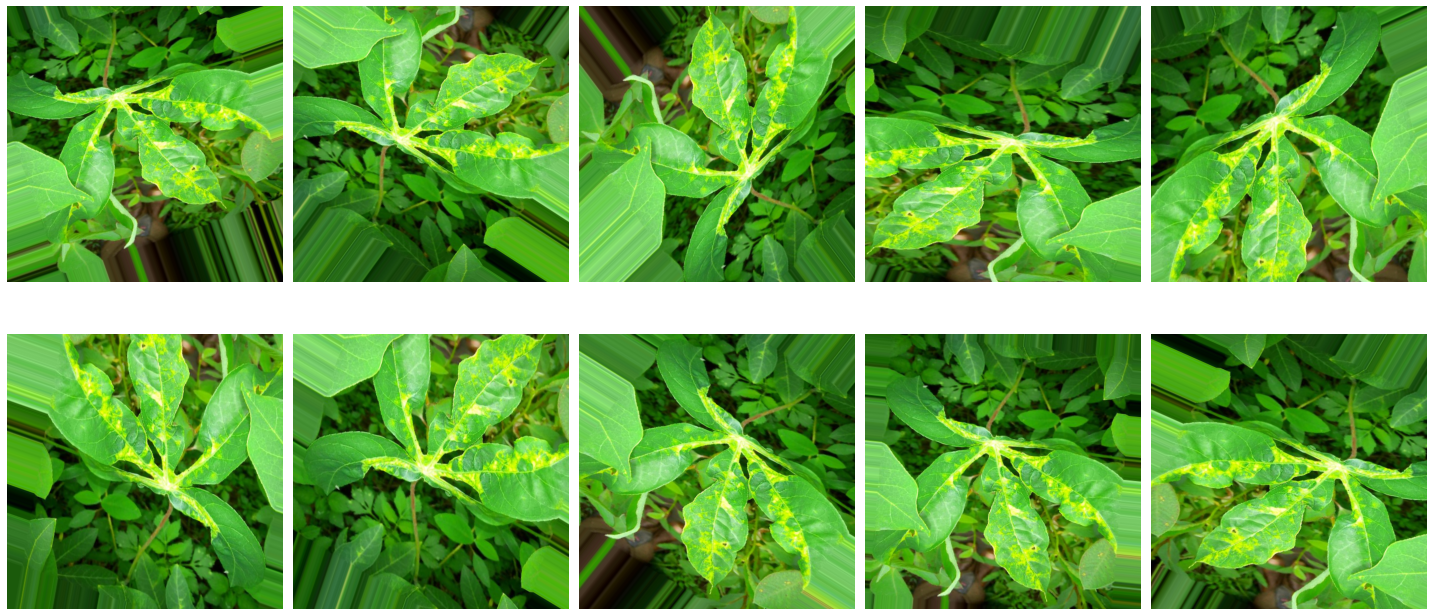

In [19]:
generator = train_datagen.flow_from_dataframe(train_labels.iloc[20:21],
                         directory = os.path.join(WORK_DIR, "train_images"),
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

aug_images = [generator[0][0][0]/255 for i in range(10)]
fig, axes = plt.subplots(2, 5, figsize = (20, 10))
axes = axes.flatten()
for img, ax in zip(aug_images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

# Modeling

# Creating the CNN

In [20]:
def create_model():
    conv_base = EfficientNetB0(include_top = False, weights = None,
                               input_shape = (TARGET_SIZE, TARGET_SIZE, 3))
    model = conv_base.output
    model = layers.GlobalAveragePooling2D()(model)
    model = layers.Dense(5, activation = "softmax")(model)
    model = models.Model(conv_base.input, model)

    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [21]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 512, 512, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 513, 513, 3)  0           ['normalization[0][0]']      

In [22]:
print('Our EfficientNet CNN has %d layers' %len(model.layers))

Our EfficientNet CNN has 239 layers


# Loading Weights

In [23]:
model.load_weights('/Users/Shadin/Desktop/Deep Learning/models/EfNetB0_275_16.h5')

# Traing 

In [ ]:
model_save = ModelCheckpoint('./EffNetB0_512_8_best_weights.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)


history = model.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save, early_stop, reduce_lr]
)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

In [ ]:
model.save('./EffNetB0_512_8.h5')